<a href="https://colab.research.google.com/github/schokoro/cnn_crf_nertagger/blob/dev/NER_tagger.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN и CRF для извлечения именованных сущностей



In [1]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if device == 'cpu':
    print('cpu')
else:
    n_gpu = torch.cuda.device_count()
    print(torch.cuda.get_device_name(0))
    

Tesla T4


In [0]:
import sys
sys.path.append('/content/cnn_crf_nertagger')

In [3]:
!rm -rf cnn_crf_nertagger/
!git clone -b dev https://github.com/schokoro/cnn_crf_nertagger.git > /dev/null
!pip install allennlp wget youtokentome ipymarkup seqeval livelossplot> /dev/null


Cloning into 'cnn_crf_nertagger'...
remote: Enumerating objects: 273, done.
remote: Counting objects: 100% (273/273), done.
remote: Compressing objects: 100% (173/173), done.
remote: Total 273 (delta 135), reused 204 (delta 79), pack-reused 0
Receiving objects: 100% (273/273), 211.36 KiB | 1.18 MiB/s, done.
Resolving deltas: 100% (135/135), done.


In [0]:
%load_ext autoreload
%autoreload 2

import spacy
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from torch.nn import functional as F
from torch.utils.data import TensorDataset
from allennlp.data.dataset_readers.conll2003 import Conll2003DatasetReader
from allennlp.common.util import ensure_list
# from allennlp.data.vocabulary import Vocabulary
from allennlp.training.metrics import SpanBasedF1Measure
from torch import nn
from torch.nn import functional as F
# from torch.utils.data import TensorDataset
from pdb import set_trace
from gc import collect
from tqdm.notebook import tqdm
import wget
from multiprocessing import cpu_count
import cnn_crf_nertagger
from cnn_crf_nertagger.modules.modules import NERTaggerModel, NERTagger
from cnn_crf_nertagger.utils.pipeline import train_eval_loop, predict_with_model
from cnn_crf_nertagger.utils.prepare import tag_corpus_to_tensor, tokenize_corpus, make_yttm_tokenizer, highlight_text, tensor_to_tags, ConllDataset
from os import path, listdir
import pandas as pd
import seaborn as sns
from matplotlib import rcParams
from seqeval.metrics import classification_report
sns.set()
%matplotlib inline

rcParams['figure.figsize'] = 12, 12
torch.backends.cudnn.deterministic=False 

## Подготовка данных




### Загружаем корпуса

In [5]:
!rm -fv /content/cnn_crf_nertagger/data/*


removed '/content/cnn_crf_nertagger/data/readme.txt'


In [0]:
path_data = '/content/cnn_crf_nertagger/data/'
path_train = '/content/cnn_crf_nertagger/data/eng.train'
path_valid = '/content/cnn_crf_nertagger/data/eng.testa'
path_test = '/content/cnn_crf_nertagger/data/eng.testb'

dataset_urls = {
    'eng.testa': 'https://raw.githubusercontent.com/synalp/NER/master/corpus/CoNLL-2003/eng.testa',
    'eng.testb': 'https://raw.githubusercontent.com/synalp/NER/master/corpus/CoNLL-2003/eng.testb',
    'eng.train': 'https://raw.githubusercontent.com/synalp/NER/master/corpus/CoNLL-2003/eng.train'}
for file_name in dataset_urls:
    wget.download(dataset_urls[file_name], path.join(path_data, file_name))

In [7]:
%%time
conll_reader = Conll2003DatasetReader()
train_conll = ensure_list(conll_reader.read(path_train))
valid_conll = ensure_list(conll_reader.read(path_valid))
test_conll = ensure_list(conll_reader.read(path_test))

14041it [00:01, 12247.90it/s]
3250it [00:00, 9073.05it/s]
3453it [00:00, 23470.48it/s]

CPU times: user 1.58 s, sys: 70.5 ms, total: 1.65 s
Wall time: 1.66 s


In [8]:
all_conll = train_conll + valid_conll + test_conll
len(all_conll), len(train_conll), len(valid_conll), len(test_conll)

(20744, 14041, 3250, 3453)

### Готовим словари соответсвия тег-id и bpe - токенизатор



In [9]:
tags = set()
tokens = set()

max_sent_len = 0
for instance in all_conll[: ]:
    if len(instance['tokens']) >  max_sent_len:
        max_sent_len = len(instance['tokens'])
    tags.update(instance['tags'])
    tokens.update(instance['tokens'])
    
print(f'Максимальная длина предложения: {max_sent_len} токенов')

Максимальная длина предложения: 124 токенов


In [10]:
%time bpe_tokenizer = make_yttm_tokenizer(train_conll, 400)

CPU times: user 137 ms, sys: 35.8 ms, total: 173 ms
Wall time: 130 ms


In [11]:
%%time
max_token_len = 0
for p in tqdm(range(101)):
    len_tokens = [len(bpe_tokenizer.encode(token.text, dropout_prob=p/100))  for token in tokens]
    if max(len_tokens) > max_token_len:
        p_dropout = .01 * p
        max_token_len = max(len_tokens)

print(f'Максимальная длина токена: {max_token_len} субтокенов при вероятности дропаута {p_dropout}')


Максимальная длина токена: 62 субтокенов при вероятности дропаута 0.11
CPU times: user 9.19 s, sys: 53 ms, total: 9.24 s
Wall time: 9.24 s


In [0]:
tag2id = {tag: num for num, tag in enumerate(['<NOTAG>'] + list(tags))}

В датасете присутствует очень мало тегов вида B-XXX. Попробуем чуть размножить предложения с этими тегами. Использование дропаута в bpe внесёт немного разнообразия в эти предложения.

In [13]:
%%time
BPE_DROPOUT = .2
train_dataset = ConllDataset(train_conll, bpe_tokenizer, tag2id, max_sent_len, max_token_len, 50, BPE_DROPOUT)
valid_dataset = ConllDataset(valid_conll, bpe_tokenizer, tag2id, max_sent_len, max_token_len)
test_dataset = ConllDataset(test_conll, bpe_tokenizer, tag2id, max_sent_len, max_token_len)


CPU times: user 16.7 ms, sys: 983 µs, total: 17.7 ms
Wall time: 17.7 ms


In [14]:
len(train_dataset), len(valid_dataset), len(test_dataset) 

(16641, 3250, 3453)

## Создаём и обучаем сеть

In [0]:
models_path = '/content/cnn_crf_nertagger/models/best_model.pth'

In [16]:
try:
    del model    
    collect()
except:
    print('no model')
finally:
    torch.cuda.empty_cache()


no model


Сеть состоит из двух однотипных свёрточных блоков и CRF. На первом уровне мы осуществляем свёртку над субтокенами и делаем глобал-пуллинг. Затем получившиеся эмбедденги токенов передаём на следующий свёрточный блок. Он значительно глубже, чтобы увеличить рецептивное поле. Выход второго блока передаём в CRF, который возвращает нам `log-likelihood`.

In [17]:
torch.cuda.empty_cache()
model = NERTaggerModel(len(bpe_tokenizer.vocab()), len(tag2id), tag2id, embedding_size=64,
                                              single_backbone_kwargs=dict(layers_n=2, kernel_size=3, dropout=0.25, dilation=[1, 2]),
                                              context_backbone_kwargs=dict(layers_n=4, kernel_size=3, dropout=0.25, dilation=[1, 1, 2 , 2]))
print('Количество параметров', sum(np.product(t.shape) for t in model.parameters()))

Количество параметров 100517


In [0]:
# try:
#     model.load_state_dict(torch.load(models_path))
# except:
#     print('no model')

In [0]:
losses = {}

In [20]:
(best_val_loss,
 best_model,
 losses) = train_eval_loop(
     model,
     train_dataset,
     valid_dataset,
     lr=5e-3,
     epoch_n=200,
     batch_size=128,
     device=device,
     early_stopping_patience=8,
     l2_reg_alpha = 1e-6,
     max_batches_per_epoch_train=100,
     max_batches_per_epoch_val=100,
     dataloader_workers_n=cpu_count(),
     lr_scheduler_ctor=lambda optim: torch.optim.lr_scheduler.ReduceLROnPlateau(
         optim, patience=4,
         factor=0.1,
         threshold=1e-2,
         verbose=True),
     verbose_batch=False,
     verbose_liveloss=False,
     prev_loss=losses
    )
 
torch.save(best_model.state_dict(), models_path)

Эпоха 0
Эпоха: 101 итераций, 26.81 сек
Среднее значение функции потерь на обучении 8.134181433384962
Среднее значение функции потерь на валидации 3.4818560572770925
Новая лучшая модель!

Эпоха 1
Эпоха: 101 итераций, 27.03 сек
Среднее значение функции потерь на обучении 2.980026039746728
Среднее значение функции потерь на валидации 2.460226822357911
Новая лучшая модель!

Эпоха 2
Эпоха: 101 итераций, 26.75 сек
Среднее значение функции потерь на обучении 2.2250967934580133
Среднее значение функции потерь на валидации 2.0264229957874003
Новая лучшая модель!

Эпоха 3
Эпоха: 101 итераций, 26.79 сек
Среднее значение функции потерь на обучении 1.8753874313713301
Среднее значение функции потерь на валидации 1.805140386407192
Новая лучшая модель!

Эпоха 4
Эпоха: 101 итераций, 26.93 сек
Среднее значение функции потерь на обучении 1.631031653668621
Среднее значение функции потерь на валидации 1.6393384062326872
Новая лучшая модель!

Эпоха 5
Эпоха: 101 итераций, 27.61 сек
Среднее значение функции п

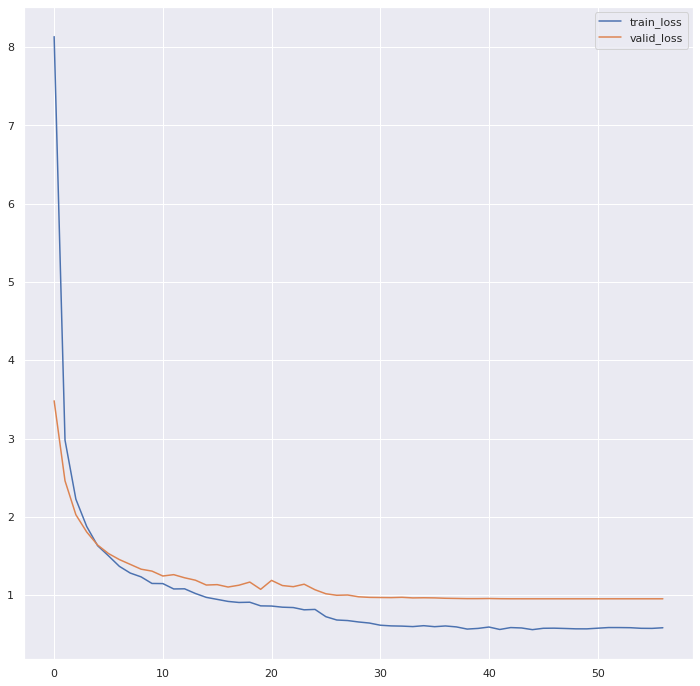

In [21]:
pd.DataFrame(losses).plot();

In [22]:
model.load_state_dict(torch.load(models_path))

<All keys matched successfully>

## Проверки

In [0]:
id2tag = {item[1]: item[0] for item in tag2id.items()}
UNIQUE_TAGS = [id2tag[i] for i in range(len(tag2id))]


### Проверка - train

In [24]:
%%time 
train_targets = [item[1] for item in train_dataset]
train_targets = torch.stack(train_targets)
train_targets.shape

CPU times: user 7.68 s, sys: 44.5 ms, total: 7.73 s
Wall time: 7.73 s


In [25]:
train_pred = predict_with_model(model, train_dataset)
train_golden_tags = tensor_to_tags(train_targets, id2tag)
train_pred_tags = tensor_to_tags(train_pred, id2tag)
print(classification_report(train_golden_tags, train_pred_tags, digits=4))
print(classification_report(train_golden_tags, train_pred_tags, digits=4, suffix=True))


521it [00:30, 16.93it/s]                               


           precision    recall  f1-score   support

      ORG     0.8147    0.8026    0.8086      8521
     MISC     0.8451    0.8138    0.8291      7588
      LOC     0.9507    0.8996    0.9244      9540
      PER     0.9169    0.9599    0.9379      7250

micro avg     0.8836    0.8680    0.8757     32899
macro avg     0.8837    0.8680    0.8754     32899

           precision    recall  f1-score   support

        I     0.9062    0.9519    0.9285     30278
        B     0.7206    0.5966    0.6528      2754

micro avg     0.8938    0.9223    0.9078     33032
macro avg     0.8907    0.9223    0.9055     33032



### Проверка - valid

In [26]:
%%time 
valid_targets = [item[1] for item in valid_dataset]
valid_targets = torch.stack(valid_targets)
valid_targets.shape

CPU times: user 1.35 s, sys: 1.11 ms, total: 1.36 s
Wall time: 1.36 s


In [27]:
valid_pred = predict_with_model(model, valid_dataset)

 
valid_golden_tags = tensor_to_tags(valid_targets, id2tag)
valid_pred_tags = tensor_to_tags(valid_pred, id2tag)
print(classification_report(valid_golden_tags, valid_pred_tags, digits=4))
print(classification_report(valid_golden_tags, valid_pred_tags, digits=4, suffix=True))


100%|██████████| 102/101.5625 [00:06<00:00, 16.63it/s]


           precision    recall  f1-score   support

      ORG     0.7298    0.7733    0.7509      1341
      LOC     0.8871    0.8938    0.8905      1837
     MISC     0.8331    0.8015    0.8170       922
      PER     0.8649    0.8795    0.8721      1842

micro avg     0.8352    0.8479    0.8415      5942
macro avg     0.8363    0.8479    0.8419      5942

           precision    recall  f1-score   support

        I     0.9128    0.9302    0.9214      5899
        B     0.1000    0.2500    0.1429         4

micro avg     0.9115    0.9297    0.9205      5903
macro avg     0.9123    0.9297    0.9209      5903



### Проверка - test

In [28]:
%%time 
test_targets = [item[1] for item in test_dataset]
test_targets = torch.stack(test_targets)
test_targets.shape

CPU times: user 1.18 s, sys: 2.22 ms, total: 1.18 s
Wall time: 1.19 s


In [29]:
test_pred = predict_with_model(model, test_dataset)
 
test_golden_tags = tensor_to_tags(test_targets, id2tag)
test_pred_tags = tensor_to_tags(test_pred, id2tag)
print(classification_report(test_golden_tags, test_pred_tags, digits=4))
print(classification_report(test_golden_tags, test_pred_tags, digits=4, suffix=True))

100%|██████████| 108/107.90625 [00:05<00:00, 18.32it/s]


           precision    recall  f1-score   support

      ORG     0.6877    0.7477    0.7165      1661
     MISC     0.6595    0.7009    0.6796       702
      LOC     0.8450    0.8435    0.8443      1668
      PER     0.8147    0.8318    0.8231      1617

micro avg     0.7645    0.7943    0.7791      5648
macro avg     0.7670    0.7943    0.7802      5648

           precision    recall  f1-score   support

        I     0.8801    0.9193    0.8993      5599
        B     0.0000    0.0000    0.0000        18

micro avg     0.8792    0.9163    0.8974      5617
macro avg     0.8773    0.9163    0.8964      5617



           precision    recall  f1-score   support

      PER       0.86      0.84      0.85      1617
      LOC       0.81      0.87      0.84      1668
      ORG       0.72      0.77      0.74      1661
     MISC       0.75      0.73      0.74       702

    micro avg   0.79      0.81      0.80      5648
    macro avg   0.79      0.81      0.80      5648

           precision    recall  f1-score   support

        I       0.91      0.94      0.92      5599
        B       0.11      0.06      0.07        18

    micro avg   0.91      0.94      0.92      5617
    macro avg   0.91      0.94      0.92      5617


## Применение теггера

In [0]:
!python -m spacy download en_core_web_sm > /dev/null
nlp = spacy.load('en_core_web_sm')

In [0]:

ner_tagger = NERTagger(model, bpe_tokenizer, UNIQUE_TAGS, max_sent_len, max_token_len, 0)

Несколько предложений из новостей с сайта [BBC](https://www.bbc.com/news)

In [0]:
test_sentences = [
    'Mr Trump said Mr Linick no longer had his full confidence and that he would be removed in 30 days.',
    'Mr Linick had begun investigating Secretary of State Mike Pompeo for suspected abuse of office, reports say.',
    'Democrats say Mr Trump is retaliating against public servants who want to hold his administration to account.',
    'Donald Trump, who is campaigning for re-election in November, has stepped up his attacks on China in recent weeks, blaming it for the spread of Covid-19.',
    'The team led by Fernando Novas from the Natural Sciences Museum in Buenos Aires discovered many fossils during its month-long field work in Estancia La Anita, in southern Santa Cruz province.',
    "The rehearsal at Kennedy Space Center saw a Falcon-9 vehicle's ascent into the sky deliberately terminated just 80 seconds after lift-off."
]
test_sentences_tokenized = tokenize_corpus(test_sentences)
# test_sentences_tokenized = [[token.text for token in nlp.tokenizer(sent) ] for sent in test_sentences]

In [33]:
for sent_tokens, sent_tags in zip(test_sentences_tokenized, ner_tagger(test_sentences)):
    highlight_text(sent_tokens, sent_tags)

1it [00:00, 70.79it/s]                    
